# Practical: Data Analysis

In this assignment you will experiment with

- exploring the data collected at a home and a weather station around the Eindhoven area,
- building a predictive model for estimating the amount of electricity produced at the home given a weather forecast.

This notebook will guide you through the typical steps that such work would involve. It shows how to build a simple linear model and your task is to improve on it, i.e. train a model that will provide a more accurate prediction than the simple one.

#### Goal

Your task is to train a model on the time series data containing:

- measurements of the amount of electricity produced by the solar panels on the roof of a home in the Eindhoven area
- weather measurements around the Eindhoven airport

in order to predict the hourly solar panel output given the weather forecast for a particular hour of a particular day.

#### Jupyter notebooks

For those who are new to jupyter notebooks, a typical notebook contains text cells (like this one) interleaved with code cells (the gray boxes). You can execute a cell by selecting it and pressing Shift+Enter. The expression in the last line in a cell is the output of that cell. Try executing the following cell.

In [1]:
def add(a, b):
    return a + b

add(1,5)

6

You can find out more about jupyter notbooks at:

- https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/
- http://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb
- http://nbviewer.jupyter.org/github/jupyter/notebook/tree/master/docs/source/examples/Notebook/

#### References

The "Python Data Scinence Handbook" provides a good overview of using python for data data analysis and you are encouraged to consult it during this assignment:

- https://jakevdp.github.io/PythonDataScienceHandbook/

The "Introduction to Statistical Learning" [ISLR] book provides a good introduction to machine learning from the statistical perspective:

- http://www-bcf.usc.edu/~gareth/ISL/

#### Deliverable

Throughout this notebook you will find cells starting with **TODO: ...** or `# TODO: ...`. Fill in all these TODO cells. You are encouraged to play with the data and extend this notebook with any interesting insights, beyond the TODOs. At the end, deliver the filled in `assignment.ipynb` file.

**Important:** Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu.

Let's get started!

### Import the relevant libraries

In this assignment we will be using mainly the following libraries:

- `pandas` for organizing the data
- `numpy` for operating on the data
- `matplotlib` for visualizing the data
- `sklearn` for training and evaluating a model on the data
- other utility libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.covariance import *
from sklearn.neighbors import *
import glob

### Read the data

The data resides in two files:

In [3]:
raw_energy = pd.read_csv("energy_train.csv")
raw_energy.head()

C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,time,seconds,total_consumption,total_production,solar_production,total_solar_production
0,2017-01-01,01:00:01,1483228801,13188.301,4499.785,0,4147.1
1,2017-01-01,01:00:11,1483228811,13188.302,4499.785,0,4147.1
2,2017-01-01,01:00:21,1483228821,13188.304,4499.785,0,4147.1
3,2017-01-01,01:00:31,1483228831,13188.305,4499.785,0,4147.1
4,2017-01-01,01:00:41,1483228841,13188.307,4499.785,0,4147.1


In [4]:
raw_weather = pd.read_csv("weather_train.csv")
raw_weather.tail()

,time,sun,temperature,chill,humidity,wind direction,wind speed,visibility,air pressure
16678,2017-05-24T23:10:00Z,3.0,12.4,NaN,90.0,WNW,2.0,28900.0,1025.0
16679,2017-05-24T23:20:00Z,2.0,12.7,NaN,90.0,NW,2.0,27500.0,1025.0
16680,2017-05-24T23:30:00Z,2.0,12.3,NaN,91.0,NW,2.0,24500.0,1024.9
16681,2017-05-24T23:40:00Z,2.0,12.3,NaN,91.0,NW,2.0,23100.0,1024.9
16682,2017-05-24T23:50:00Z,3.0,12.2,NaN,91.0,NNW,2.0,21800.0,1024.9


When analysing data it is important to understand its semantics. In IoT one needs to be extra careful, especially when integrating data from various sources. The very basic information are the units of the measurements, but also the specifications of the sensors gathering the data and the processes that are being monitored. For example, in this case the specification of the solar panel instalation states that it can generate max 42 Jouls per minute.  

Assume the following for the energy data:
- `seconds` is the time the sample was recorded (UTC)
- `total_consumption` is the total amount of electricity that was pulled from the grid (kWh)
- `total_production` is the total amount of electricity that was pushed into the grid (kWh)
- `solar_production` is the amount of eletricity that was produced since the last sample (Wh).
- `total_solar_production` is the total amount of electricity produced by the solar panels (kWh)

Assume the following for the weather data:
- `time` is the time the sample was recorded (UTC)
- `sun` measures whether it was cloudy or sunny at the time when the sample was taken, ranging from 0-3, 0 meaning cloudy and 3 meaning sunny.
- `temperature` is the still temperature (C)
- `chill` is the temperature with the wind chill effect taken into account (C)
- ...

### Explore the data

Exploration is usually the first step in any data analysis task. Visualization is an important tool for exploring the data. It gives insights into the structure and semantics of the data and indications for how to clean it.

The `matplotlib` library provides a collection of useful plots, such as a line plot, scatter plot, histogram, scatter mattrix, etc. You can find out more about this library at 

- https://matplotlib.org/users/pyplot_tutorial.html
- https://matplotlib.org/devdocs/gallery/

The `pandas` library also contains convenient wrappers around the `matplotlib` library for visualizing data frames and series:

- https://pandas.pydata.org/pandas-docs/stable/visualization.html

Let's draw a simple plot of the energy data:

- ### Energy plots

In [5]:
days = (raw_energy["seconds"] - raw_energy["seconds"][0])/(60*60*24);
total_solar_production = raw_energy["total_solar_production"] - raw_energy["total_solar_production"][0];
total_production = raw_energy["total_production"] - raw_energy["total_production"][0];
total_consumption = raw_energy["total_consumption"] - raw_energy["total_consumption"][0];

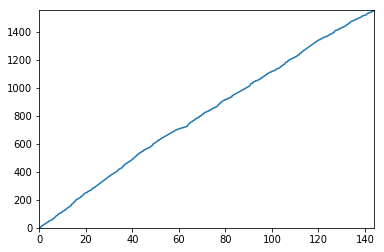

In [6]:
X = days
Y = total_consumption
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()]);

Consumption is linear throughout time! During a span of aproximately 145 days. (1-Jan to 25-May)

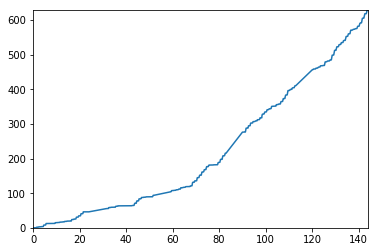

In [7]:
X = days
Y = total_production
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()]);

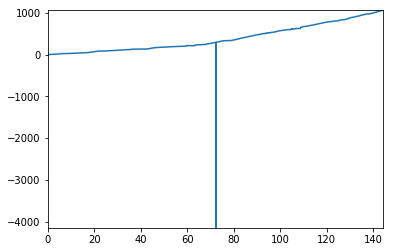

In [8]:
X = days
Y = total_solar_production
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()]);

Solar panels more active after aproximately 10-March (day : 70) $ => $ more sun, better conditions

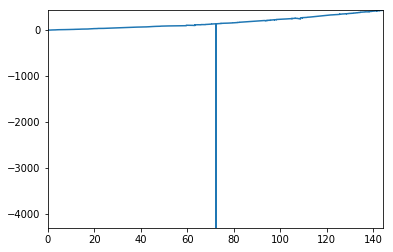

In [9]:
X = days
Y = total_solar_production - total_production
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()]);

Total solar consumption, assuming the solar panel is the only thing pushing its excessive energy to the grid.

Decreases in this function can be considered abnormal discharges to the grid.

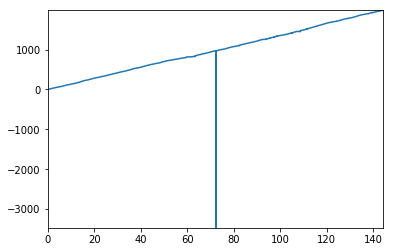

In [10]:
X = days
Y = total_consumption + total_solar_production - total_production
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()]);

Total energy consumed (from the grid and from the panels)

**Check something wrong about solar production!**

- ### Weather plots

In [11]:
times = pd.to_datetime(raw_weather["time"]).dt.dayofyear;

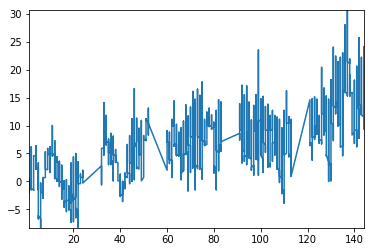

In [12]:
X = times
Y = raw_weather["temperature"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()]);

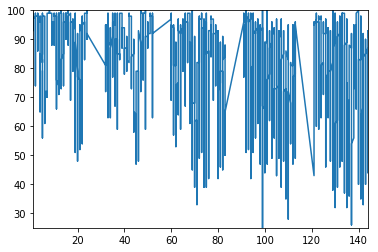

In [13]:
X = times
Y = raw_weather["humidity"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()]);

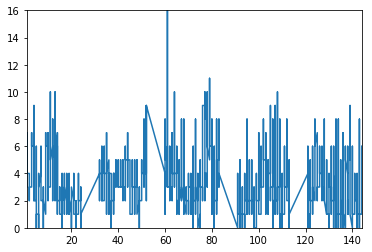

In [14]:
X = times
Y = raw_weather["wind speed"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()]);

- ### Energy vs Weather plots

### Clean the data

Data cleaning is an important part of any data analysis task. According to the general wisdom, most effort actually is spent on data cleaning. It involves preparing the data for the following steps, e.g. filling in missing values, removing outliers, normalizing the data, etc.

In the plot above you will have noticed vertical lines. These lines correspond to 0 values and are likely to be measuring errors (e.g. the solar panel meter has crashed). Such outliers will often negatively impact the accuracy of the predictive model and should be removed.

Pandas provides convenient methods for selecting subsets of the data that can be used for removing outliers:

- https://jakevdp.github.io/PythonDataScienceHandbook/03.02-data-indexing-and-selection.html

In [15]:
raw_energy = raw_energy[raw_energy.total_solar_production > 0]

### Engineer features

The goal of this assignment is to predict the hourly energy output of the solar panels given the weather forecast. This requires to relate the energy samples with the weather samples, basically attaching the energy production label to the weather measurements. However, the *total* energy and weather samples are taken approximately every 10 seconds and 10 minutes, respectively.

####  Aggregate per hour

We can use pandas grouping functions to aggregate the samples per hour, taking the largest  measurement in that hour.

In [16]:
col = "total_solar_production"
energy = raw_energy
times = pd.to_datetime(energy["seconds"], unit='s')

energy = energy.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])[[col]].agg(np.max)
energy.index.names = ["year", "month", "day", "hour"]
energy.head()

total_solar_production
year month day hour                        
2017 1     1   0                     4147.1
               1                     4147.1
               2                     4147.1
               3                     4147.1
               4                     4147.1

**Todo:** Note that the hourly aggregation using the maximum works well for columns containing the totals. Does it also work the `solar_production` column? Motivate your answer.

<font color='blue'>** R: ** No, because the aggregation would just hold the maximum solar production since the last sample, neglecting other important solar productions different from 0.</font>

After aggregation, some cells can contain `Nan` values (e.g. when trying to compute a maximum for an hour during which no samples were recorded). Therefore, after performing such operations one should decide what to do with any Nans. In this case we chose to remove such samples.

In [17]:
energy = energy.dropna()

After grouping, merging and slicing operations, the index of a data frame might need to be recomputed, to reflect the new ordering of rows.

In [18]:
energy = energy.reset_index()
energy.head()

,year,month,day,hour,total_solar_production
0,2017,1,1,0,4147.1
1,2017,1,1,1,4147.1
2,2017,1,1,2,4147.1
3,2017,1,1,3,4147.1
4,2017,1,1,4,4147.1


#### Compute the hourly production

We are interested in predicting the solar panel output in a given hour. However, the energy data frame so far contains only the total solar panel output until the end of that hour. Assuming that the data set contains a sample for every hour, i.e. there are no gaps, the hourly output can be computed by taking the difference between the previous sample.

In [19]:
energy["production"] = energy[col] - energy[col].shift(1)
energy = energy.dropna().reset_index()
#energy.drop(columns=['index'],inplace = True)
energy.head()

,index,year,month,day,hour,total_solar_production,production
0,1,2017,1,1,1,4147.1,0.0
1,2,2017,1,1,2,4147.1,0.0
2,3,2017,1,1,3,4147.1,0.0
3,4,2017,1,1,4,4147.1,0.0
4,5,2017,1,1,5,4147.1,0.0


**TODO:** after creating the `production` column the Nans are droppend and the index is recomputed. Why?

<font color='blue'>** R: ** Because otherwise, at the index 0, we would have a NaN value in the "production" column, because when we shift the dataframe energy["total_solar_production"] by 1 the there is no value for the index 0. Logically, there is no hour before the hour 0 of day 1 and month 1, so we cannot have a difference value for that hour.</font>

Now we can perform a similar aggregation for the `sun` column in the weather data. Note that rather than chosing the maximum, we take the average `sun` value per hour.

In [20]:
weather = raw_weather
times = pd.to_datetime(weather["time"])
weather = weather.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])[["sun","temperature","humidity","wind speed","visibility","air pressure"]].agg(np.mean)
weather.index.names = ["year", "month", "day", "hour"]
weather = weather.reset_index()
weather.head()

,year,month,day,hour,sun,temperature,humidity,wind speed,visibility,air pressure
0,2017,1,1,0,0.0,-1.650000,99.0,3.000000,275.500000,1025.550000
1,2017,1,1,1,0.0,-1.416667,99.0,3.166667,392.500000,1024.650000
2,2017,1,1,2,0.0,-1.300000,99.0,4.000000,332.333333,1024.066667
3,2017,1,1,3,0.0,-1.216667,99.0,3.333333,511.500000,1023.166667
4,2017,1,1,4,0.0,-1.216667,99.0,3.333333,1758.333333,1022.266667


#### Merge the data frames

Now that both data frames are expressed in terms of hours and the energy data frame contains the hourly solar panel output, we can use pandas to merge them.

**Important:** when dealing with times in data from various sources one must be very carefull about the semantics of the time, such as the time-zone or the daylight-saving. Luckily, in this assignment both energy and weather data use UTC time, so no extra preprocessing is required.

In [21]:
data = pd.merge(energy, weather).dropna().reset_index(drop=True)
data[35:40]

,index,year,month,day,hour,total_solar_production,production,sun,temperature,humidity,wind speed,visibility,air pressure
35,36,2017,1,2,12,4151.6,0.9,3.000000,5.300000,80.333333,2.833333,14750.000000,1024.100000
36,37,2017,1,2,13,4152.2,0.6,1.333333,5.933333,75.166667,3.000000,19950.000000,1024.183333
37,38,2017,1,2,14,4152.4,0.2,2.666667,4.566667,77.833333,2.666667,37466.666667,1024.450000
38,39,2017,1,2,15,4152.5,0.1,0.500000,4.183333,80.166667,2.666667,43900.000000,1024.633333
39,40,2017,1,2,16,4152.5,0.0,0.000000,3.266667,86.500000,2.500000,37516.666667,1024.966667


#### Explore the engineered features

After engineering features it is a good idea to explore the data set again, to see if extra cleaning is required.

(0.0, 87.399999999999636)
0


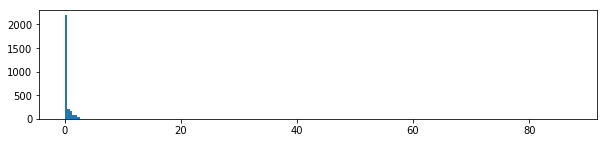

In [22]:
values = data["production"].values
plt.figure(figsize=(10, 2))
plt.hist(values, 200);
print (min(values), max(values))
print (len(data[data.production == 0]) / len(values))

The small variance of the values and their large range suggests there are some outliers. This can be also visualized in a different way.

<font color='blue'> Around 60% of the values are 0. </font>

0


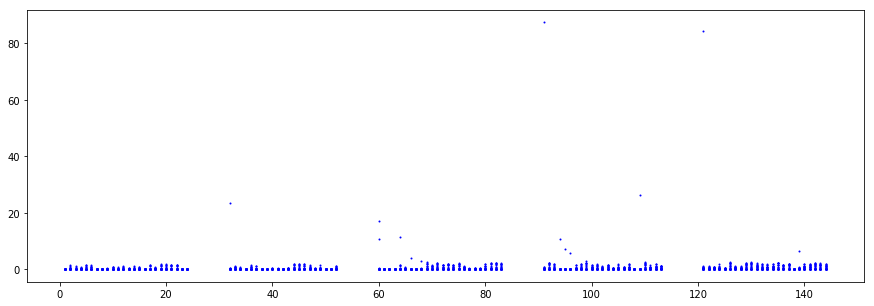

In [23]:
def plot(df, col):
    x = df["day"]
    plt.figure(figsize=(15,5))
    plt.plot(x, df[col], 'bo', markersize=1)

plot(data, "production")
print(10 / len(values))

The figure suggests that there are indeed outliers in the energy production data.

**TODO:** How do you explain these outliers?

<font color="blue">**R:** Eletromagnetic momentanium charges in the solar production tracking sensor? </font>

Note that when removing the energy samples containing 0 values in `raw_energy` earlier, it was clear how to define an outlier. In this case, however, one must carefully decide how to define an outlier, to avoid introducing bias. You can read more about outlier detection here:

- Section 3.3.3 of "Introduction to Statistical Learning"
- http://scikit-learn.org/stable/modules/outlier_detection.html

**TODO**: How do you define an outlier for this data set?

<font color="blue">**R:** We used the Local Outlier Factor method, which defines a sample as an outliers if it has its local density much lower than the average density of its k-nearest neighbors, in our case k=20 (default value) and the metric used was the Minkowski distance (default metric). </font>

In [24]:
# Remove the outliers
# -> Outliers identification

#train_values = np.column_stack((values,data["day"])); #features: production, day
#train_values = values.reshape(-1,1); --still commented

#clf_lof = LocalOutlierFactor(contamination = 0.02) #  2% of outliers
#y_pred_lof = clf_lof.fit_predict(train_values)

# Coen's
n = len(data.index)
mean_production = data["production"].mean()

nominator = 1/n + (data["production"] - mean_production)**2
denominator = data["production"].var() * n

data["leverage"] = nominator / denominator
mean_leverage = data["leverage"].mean()

data.loc[data.leverage < 2 * mean_leverage, "outliers"] = 1
data.loc[data.leverage >= 2 * mean_leverage, "outliers"] = -1

(2750, 12)


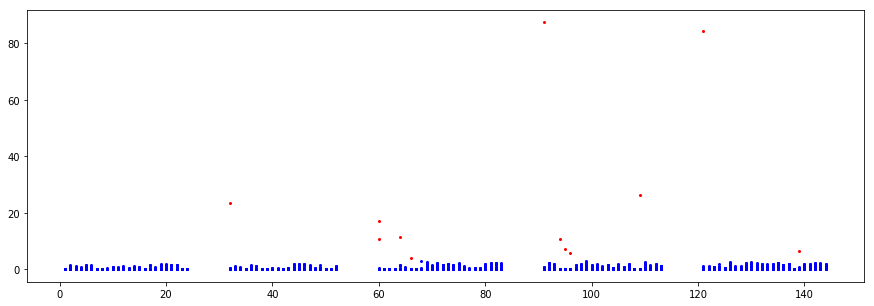

In [25]:
# Remove the outliers
# -> Outliers visualization
df_other = pd.DataFrame({"day": data["day"], "production":data["production"], "outliers":data["outliers"]});

df_in = df_other[df_other.outliers == 1];
df_out = df_other[df_other.outliers == -1];
x_in = df_in.day;
x_out = df_out.day;

plt.figure(figsize=(15,5))
plt.plot(x_in, df_in["production"], 'bo', markersize=2);
plt.plot(x_out, df_out["production"], 'ro', markersize=2);
print(len(x_in),len(x_out))

In [26]:
# Remove the outliers
# -> Clean data

data_clean = data = data[data.outliers == 1]
data_clean = data_clean.reset_index()
data_clean.drop(['outliers','leverage'], axis=1, inplace=True)

**TODO:** Is your outlier definition "fair"? Does it detect outliers that are both too large and too small?

<font color="blue">**R:** Yes, as it can be clearly seen it detects the outrageous outliers, far from the normal values. Additionally, it detects samples that are too high or too low for a specific day. **(Revisit, i think there shouldn't be outliers too low, or inside the bars)**  </font>

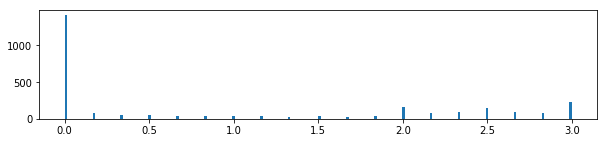

In [27]:
# Sun feature
values = data_clean["sun"].values
plt.figure(figsize=(10, 2))
plt.hist(values, 200);

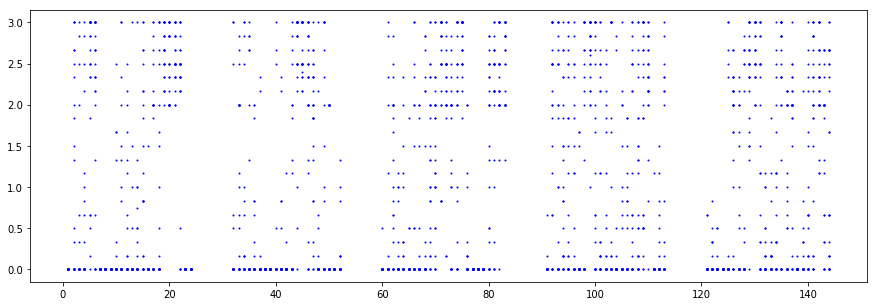

In [28]:
# Sun feature
plot(data,"sun")

**TODO:** Do you see any outliers or interesting patterns?

<font color="blue">**R:** No outliers I think. Most of the times it's cloudy. **(Uniform distribution of sun??)**</font>

### Train a model

For training and evaluating the perfromance of a model we need to split the data into a training and a test.

In [29]:
X = data_clean[["sun"]].as_matrix()
y = data_clean["production"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluate the model

After a model is trained we would like to estimate how well it is performing, whether we can actually trust its predictions if it were deployed. Model performance can be estimated using various visualisations and statistics (see Section 3.1.3 of [ISLR])

#### Model fit

If the feature space is 1 or 2 dimensional, then we can easily plot the model to illustrate how well it fits the test data.

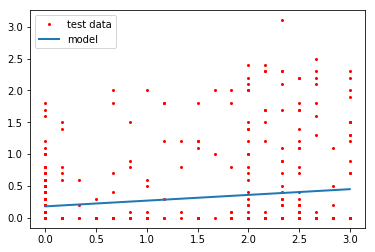

In [31]:
x_plot = np.linspace(min(X), max(X), 100)
X_plot = x_plot.reshape(-1, 1)
y_plot = model.predict(X_plot)

dots, = plt.plot(X_test, y_test, 'bo', markersize=2, color="red", label="test data");
line, = plt.plot(x_plot, y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line]);

We can compute the R2 score to assign a number to how well the model fits the data. It estimates how much of the variance in the data is explained by the model, i.e. how well the model fits the data. A score of 1 means the model captures all of the variance, and a score of 0 means the model does not capture any of the variance.

You can read more about the R2 score in Section 3.1.3 of "Introduction to Statistical Learning".

In [32]:
model.score(X_test, y_test)

0.058050690419277906

#### Residuals

We can also plot a histogram of the residuals (or errors), i.e. the deviations of the values predicted by our model from the ground truth values (from the test set):

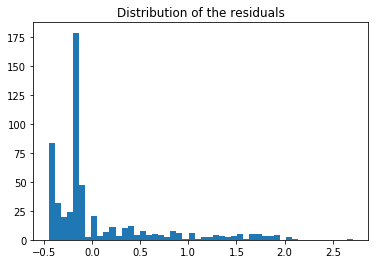

In [33]:
y_pred = model.predict(X_test)
plt.title("Distribution of the residuals")
plt.hist(y_test - y_pred, 50);

Looking at the histogram you will notice that distribution of the residuals is not symmetric.

**TODO:** Is the model biased, i.e. does it tend to under- or overestimate the solar panel output?

<font color="blue">**R:** It tends to overestimate the solar panel output, because the distribution of the residuals is more concentrated on the negative side.</font>

If the model is not biased, or if we are not interested in the bias, then we can compute the mean absolute deviation (MAD) to estimate the expected error of a prediction. E.g. in our case a MAD = 0.345 means that we expect on average our predition to be off by 0.345kWh.

In [34]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.39988441940325248

### Improve the model

We have shown here a simple linear model mapping the `sun` feature to the `hourly_production` label. However, this model does not perform very well. The problem could be that the model is underfitting or overfitting the data. You can find more about under- and overfitting in Section 2.1.2, 2.1.3, 6.1 of "Introduction to Statistical Learning".

**TODO:** Is the model underfitting or overfitting the training data?

<font color="blue">**R:** It is underfitting the training data because the model captures very poorly the relationship between input and output on the trainning data.</font>

One could try several things to improve the model.

#### Add more features

One way of improving the simple linear model could be to extend it with more features. You can gain insight into which features could be relevant by plotting the relationship between the features and the labels.

In [35]:
data_clean.tail()

,level_0,index,year,month,day,hour,total_solar_production,production,sun,temperature,humidity,wind speed,visibility,air pressure
2745,2757,2763,2017,5,144,19,5205.6,0.0,2.666667,17.516667,71.833333,3.833333,44616.666667,1024.400000
2746,2758,2764,2017,5,144,20,5205.6,0.0,2.666667,15.866667,77.333333,2.666667,46816.666667,1024.783333
2747,2759,2765,2017,5,144,21,5205.6,0.0,2.500000,14.650000,81.666667,2.000000,45950.000000,1024.900000
2748,2760,2766,2017,5,144,22,5205.6,0.0,2.666667,13.383333,87.166667,1.833333,36366.666667,1024.916667
2749,2761,2767,2017,5,144,23,5205.6,0.0,2.333333,12.416667,90.500000,2.000000,26883.333333,1024.933333


In [36]:
## Feature selection
from sklearn.feature_selection import *
X_label = ["day","hour","sun","temperature","humidity","wind speed","visibility","air pressure"]
X = data_clean[X_label].as_matrix()
y = data_clean["production"].values

#Univariate Linear Regression
scores1 = f_regression(X, y)[0]

#Mutual Information Regression
scores2 = mutual_info_regression(X, y)


#Printing results
df_scores = pd.DataFrame({"linear_r":scores1,"mut_info_r":scores2},index = X_label)
df_scores

,linear_r,mut_info_r
day,156.812300,0.065570
hour,5.049293,0.464953
sun,139.213414,0.037962
temperature,585.261366,0.125845
humidity,1159.634268,0.209059
wind speed,49.838501,0.044142
visibility,119.564620,0.104308
air pressure,11.610348,0.033270


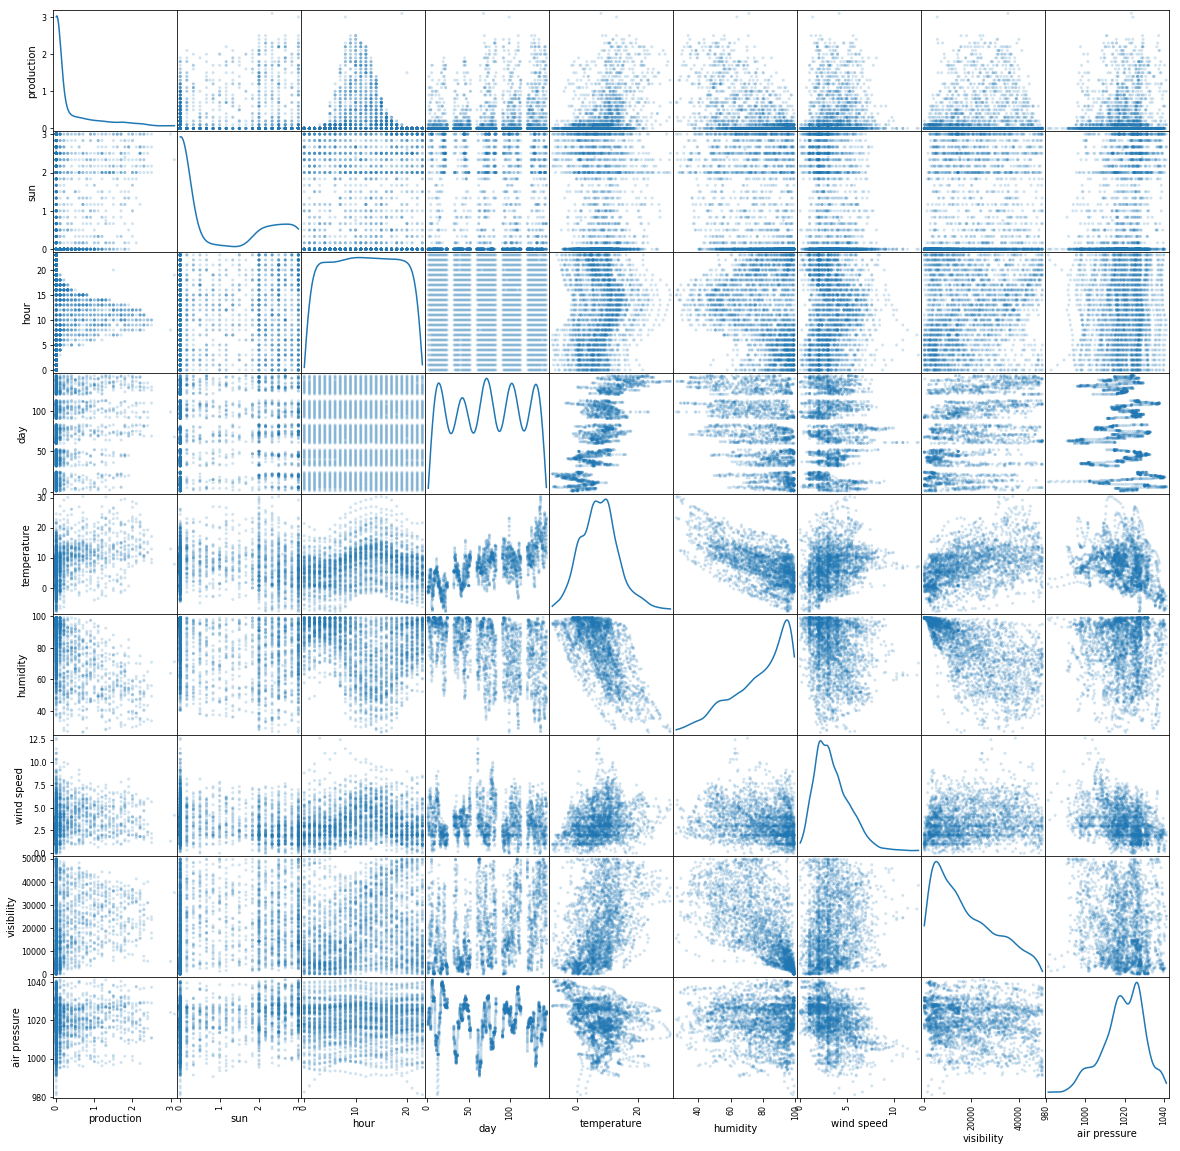

In [37]:
# TODO: use the scatter matrix graph to explore the relationship between the features
from pandas.plotting import scatter_matrix

scatter_matrix(data_clean[["production","sun","hour","day","temperature","humidity","wind speed","visibility","air pressure"]], alpha=0.2, figsize=(20, 20), diagonal='kde');

**TODO:** Which features are promising for predicting the solar panel output?

<font color="blue">**R:** After looking at all the features F scores for a univariate linear regression test, the score for the mutual information and the scatter matrix we reached to the conclusion that the features: day, hour, sun, temperature, humidity and visibility, are promising features.
</font>

**TODO:** Are there other features in the `raw_weather` data that can be used for predicting the solar panel output?

<font color="blue">**R:** The ones mentioned above.
</font>

Note that using additional features may require aggregating them per hour. The `sun` feature was aggregated taking the maximum value within a given hour, but this may not be suitable for all features.

In [38]:
X_features = [elem for elem in X_label if elem not in ("wind speed","air pressure")]
R2_scores = {}
MADs = {}

## Other linear models

### Linear Regression

This time we added all the promising new features. We see that `hour` doens't have a good linear regression score with production, but adding it to the model increases the R2 score, this is probably because `hour` has a (super)linear correlation with other features like `temperature` and `humidity`.

In [39]:
# Linear Regression (humidity, temperatue, visibility, day, sun, hour)
X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train);
y_pred = model.predict(X_test);
R2_scores["linear_regression"] = model.score(X_test, y_test)
MADs["linear_regression"] = mean_absolute_error(y_test, y_pred)

### Elastic Net

It's linear regression also but instead uses the Least Squares method with L1 and L2 priors regularization.

In [40]:
# Elastic Net (humidity, temperatue, visibility, day, sun, hour)
X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = ElasticNet(alpha=0.1)
model.fit(X_train, y_train);
y_pred = model.predict(X_test);
R2_scores["elastic_net"] = model.score(X_test, y_test)
MADs["elastic_net"] = mean_absolute_error(y_test, y_pred)

## Evalutation of linear models

In [41]:
df_eval = pd.DataFrame([R2_scores,MADs], index=["R2","MAD"])
df_eval.transpose()
#
#plt.title("Distribution of the residuals")
#plt.hist(y_test - y_pred, 50);

,R2,MAD
elastic_net,0.365603,0.312989
linear_regression,0.384455,0.312901


**TODO:** Did your model improve?

<font color="blue">**R:** Yes, for both linear models adding these promising features improved both the R2 and MAD scroes.
</font>

#### Choose a more or less flexible model

Another way is to add flexibility to the model e.g. by changing it to a polynomial model or a neural network. You can read more about simple extensions of the linear model in Section 3.3.2 and 6.2 of "Introduction to Statistical Learning".

### Polynomial Models

In [42]:
# Polynomial model
X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = make_pipeline(PolynomialFeatures(3, include_bias=False), LinearRegression())
model.fit(X_train, y_train);
y_pred = model.predict(X_test);
R2_scores["polynomial"] = model.score(X_test, y_test)
MADs["polynomial"] = mean_absolute_error(y_test, y_pred)

### Nearest Neighbors Regression

In [43]:
# NN Regression model
from sklearn.neighbors import KNeighborsRegressor
X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = KNeighborsRegressor(n_neighbors=200, weights='distance')
model.fit(X_train, y_train);
y_pred = model.predict(X_test);
R2_scores["neirest_neighbors"] = model.score(X_test, y_test)
MADs["neirest_neighbors"] = mean_absolute_error(y_test, y_pred)

### Gradient Tree Boosting Regression

array([ 0.15032745,  0.19608243,  0.0710585 ,  0.19957827,  0.18899541,
        0.19395794])

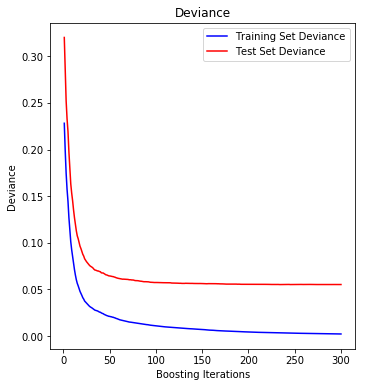

In [44]:
# GTB model
from sklearn.ensemble import GradientBoostingRegressor

X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'loss' : 'ls', 'n_estimators' : 300, 'max_depth' : 5, 'max_features' : 3}
model = GradientBoostingRegressor(**params)
model.fit(X_train, y_train);
y_pred = model.predict(X_test);
R2_scores["gradient_boosting"] = model.score(X_test, y_test)
MADs["gradient_boosting"] = mean_absolute_error(y_test, y_pred)

# Plot training deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance');
model.feature_importances_

### ADA Boost Regressor

In [45]:
# ADA Boost model
from sklearn.ensemble import AdaBoostRegressor

X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'n_estimators' : 200, 'loss' : 'square'}
model = AdaBoostRegressor(**params)
model.fit(X_train, y_train);
y_pred = model.predict(X_test);
R2_scores["ada_boosting"] = model.score(X_test, y_test)
MADs["ada_boosting"] = mean_absolute_error(y_test, y_pred)

### Random Forest Regressor

In [109]:
# Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor

X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import cross_val_score

params = {'n_estimators' : 100, 'max_features' : None, 'warm_start':True}
model = RandomForestRegressor(**params)

#model.fit(X_train, y_train);
#y_pred = model.predict(X_test);
#model.score(X_test, y_test)
#R2_scores["random_forest_reg"] = model.score(X_test, y_test)
#MADs["random_forest_reg"] = mean_absolute_error(y_test, y_pred)

scores = cross_val_score(model, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.76 (+/- 0.24)


### Neural Network

In [47]:
# Neural networks
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(250,), alpha=0.0001, max_iter=200)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled);
R2_scores["neural_net"] = model.score(X_test_scaled, y_test)
MADs["neural_net"] = mean_absolute_error(y_test, y_pred)

### Bagging Regressor

In [48]:
# Bagging Regressor model
from sklearn.ensemble import BaggingRegressor

X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

estimator = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(250,), alpha=0.0001, max_iter=200)
params = {'base_estimator' : estimator, 'n_estimators' : 10, 'max_features' : 3}
model = BaggingRegressor(**params)
model.fit(X_train_scaled, y_train);
y_pred = model.predict(X_test_scaled);
R2_scores["bagging_reg"] = model.score(X_test_scaled, y_test)
MADs["bagging_reg"] = mean_absolute_error(y_test, y_pred)

## Evalutation of all models

In [49]:
df_eval = pd.DataFrame([R2_scores,MADs], index=["R2","MAD"])
df_eval.transpose()
#
#plt.title("Distribution of the residuals")
#plt.hist(y_test - y_pred, 50);

,R2,MAD
ada_boosting,0.629293,0.274969
bagging_reg,0.711835,0.183241
elastic_net,0.365603,0.312989
gradient_boosting,0.847694,0.107658
linear_regression,0.384455,0.312901
neirest_neighbors,0.118398,0.367004
neural_net,0.831413,0.125791
polynomial,0.705752,0.210008
random_forest_reg,0.821632,0.116002


**TODO:** Select the model you find best. Why did you chose this model?

In [50]:
X_s = [elem for elem in X_features if elem not in ()]
X = data_clean[X_s].as_matrix()
y = data_clean["production"].values

params = {'loss' : 'ls', 'n_estimators' : 300, 'max_depth' : 5, 'max_features' : 3}
model = GradientBoostingRegressor(**params)
model.fit(X, y);

### Simulate the forecasting

The `weather_test.csv` file contains the weather data that was held out from `weather_train.csv` used for training the solar panel output predictor. This data simulates the weather forcasts and is used for evaluating how your model would perform if it was deployed.

Provide the predictions for the hourly solar panel output for the given weather forecasts, i.e. populate the `production` column in the following data frame:

In [51]:
prediction = pd.read_csv('weather_test.csv')
times = pd.to_datetime(prediction["time"])
prediction['month'] = times.dt.month
prediction['day'] = times.dt.dayofyear
prediction['hour'] = times.dt.hour
prediction = prediction.drop(prediction[prediction['hour'] == 0].index)
prediction = prediction.drop_duplicates().reset_index(drop=True)

prediction = prediction.groupby(["month", "day", "hour"])["sun", "temperature", "humidity", "visibility"].agg(np.mean)
prediction.index.names = ["month", "day", "hour"]
prediction = prediction.reset_index()
prediction['visibility'] = prediction['visibility'].fillna(27890)
X_final = prediction[X_s].as_matrix()

prediction = prediction[['month', 'day', 'hour']]
prediction['production'] = model.predict(X_final)
len(prediction[prediction['production']<0])
print(prediction.production.min())
prediction.head()

-0.260712017199


,month,day,hour,production
0,1,25,1,0.002153
1,1,25,2,0.005881
2,1,25,3,-0.005269
3,1,25,4,-0.009720
4,1,25,5,-0.016623


**Important:** your model will be evaluated on the held out test set. It is therefore safe to train your *final* model on the entire data set that was provided (rather than the X_train, y_train subsets from the train/test split above), to captures all of the information that is available to you.

For automating the evaluation of your predictions, call the evaluate function that is defined in the `evaluate.py` script:

In [52]:
from evaluate import *
evaluate(prediction)

'This is a stub for the evaluation function. The real implementation will compare your predictions with the held out production measurements.'

In [53]:
('production' in prediction) & (len(prediction) == 805)

True

As a sanity check, make sure that the `prediction` data frame contains a `production` column and 805 rows.